In [48]:
import warnings
from pandas import read_csv
from pandas import datetime
import pandas as pd
from statsmodels.tsa.arima_model import ARIMA
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs
from sklearn.metrics import r2_score,mean_squared_error
from collections import namedtuple
import pickle
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
import matplotlib.pyplot as plt
%matplotlib inline

# Arima


In this section the idea is to train the benchmark ARIMA. We are going tod use as background the page [How to Grid Search ARIMA Model Hyperparameters with Python](https://machinelearningmastery.com/grid-search-arima-hyperparameters-with-python/) and the udemy course [Python for Financial Analysis and Algorithmic Trading](https://www.udemy.com/python-for-finance-and-trading-algorithms/learn/v4/overview).

In [3]:
Dataset=namedtuple('Dataset','exchange df')
DatasetMLModel= namedtuple('DatasetMLModel','exchange  train_size tscv_split test_size X_train y_train X_test y_test scaler_features scaler_target')
Regressor= namedtuple('Regressor','name regressor_class params type')
FeatureSelection= namedtuple('FeatureSelection','dataset regressor params RFECV')


In [4]:
with open('datasets/log_divided_close_datasets.pkl', 'rb') as input4:
    log_divided_close_datasets = pickle.load(input4) 

In [5]:

def drop_the_last_row(dataset):
    dataset.df.drop(dataset.df.index[-1], inplace=True)
    return dataset
def make_X_Y(dataset , train_size,features=['close'],target=['close_Target']):    
    X_train=dataset.df[features][:train_size]
    y_train=dataset.df[target][:train_size]
    X_test=dataset.df[features][train_size:]
    y_test=dataset.df[target][train_size:]
    return X_train,y_train,X_test,y_test
def making_targets(dataset):
    column_targets=['Returns','close','log_return']
    for column_target in column_targets:
        dataset.df[column_target+'_Target']=dataset.df[column_target].shift(-1)
    return drop_the_last_row(dataset)
def preprossessing(dataset,features,target, train_percent=0.80,evaluation_percent=0.20  ):
    rows, columns=dataset.df.shape
    train_size= int(rows*train_percent)
    test_size=rows-train_size
    X_train,y_train,X_test,y_test=make_X_Y(dataset,train_size,features,target)
    return DatasetMLModel(dataset.exchange,train_size ,evaluation_percent,test_size,
                          X_train,y_train,X_test,y_test,scaler_features=None,scaler_target=None)

In [6]:
features=['log_return']
target=['log_return_Target']

dataset=making_targets(log_divided_close_datasets['btc_brl'])
dataset= preprossessing(dataset,features,target)



## Testing for Stationarity

We can use the Augmented [Dickey-Fuller](https://en.wikipedia.org/wiki/Augmented_Dickey%E2%80%93Fuller_test) [unit root test](https://en.wikipedia.org/wiki/Unit_root_test).

In statistics and econometrics, an augmented Dickey–Fuller test (ADF) tests the null hypothesis that a unit root is present in a time series sample. The alternative hypothesis is different depending on which version of the test is used, but is usually stationarity or trend-stationarity.

Basically, we are trying to whether to accept the Null Hypothesis **H0** (that the time series has a unit root, indicating it is non-stationary) or reject **H0** and go with the Alternative Hypothesis (that the time series has no unit root and is stationary).

We end up deciding this based on the p-value return.

* A small p-value (typically ≤ 0.05) indicates strong evidence against the null hypothesis, so you reject the null hypothesis.

* A large p-value (> 0.05) indicates weak evidence against the null hypothesis, so you fail to reject the null hypothesis.

Let's run the Augmented Dickey-Fuller test on our data:

In [14]:
dataset.X_train.tail()

,log_return
datetime,
2017-03-25,-0.013683
2017-03-26,0.000857
2017-03-27,0.027485
2017-03-28,0.010535
2017-03-29,0.002813


In [7]:
result = adfuller(dataset.X_train['log_return'])

In [8]:
print('Augmented Dickey-Fuller Test:')
labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations Used']

for value,label in zip(result,labels):
    print(label+' : '+str(value) )
    
if result[1] <= 0.05:
    print("strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary")
else:
    print("weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary ")

Augmented Dickey-Fuller Test:
ADF Test Statistic : -7.78129678723
p-value : 8.40357100835e-12
#Lags Used : 18
Number of Observations Used : 1324
strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary


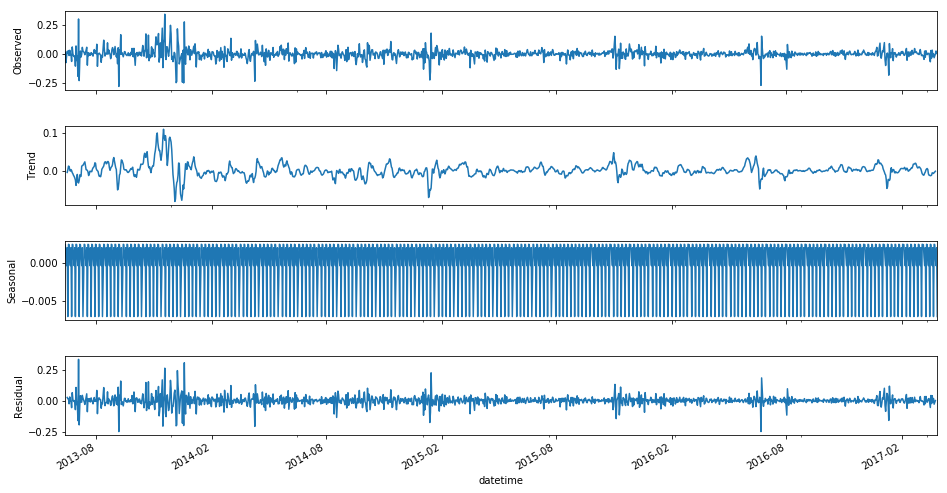

In [25]:

from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(dataset.X_train['log_return'], freq=6)  
fig = plt.figure()  
fig = decomposition.plot()  
fig.set_size_inches(15, 8)


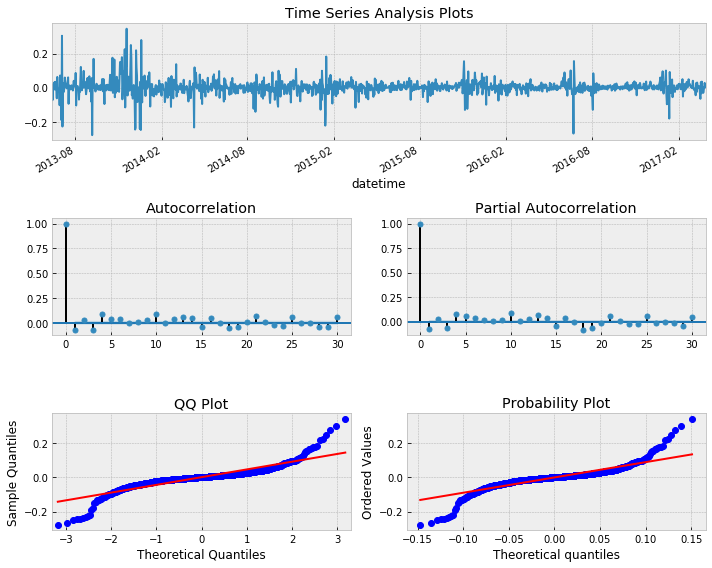

In [49]:
def tsplot(y, lags=None, figsize=(10, 8), style='bmh'):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        #mpl.rcParams['font.family'] = 'Ubuntu Mono'
        layout = (3, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        qq_ax = plt.subplot2grid(layout, (2, 0))
        pp_ax = plt.subplot2grid(layout, (2, 1))
        
        y.plot(ax=ts_ax)
        ts_ax.set_title('Time Series Analysis Plots')
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.5)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.5)
        sm.qqplot(y, line='s', ax=qq_ax)
        qq_ax.set_title('QQ Plot')        
        scs.probplot(y, sparams=(y.mean(), y.std()), plot=pp_ax)

        plt.tight_layout()
    return 

tsplot(dataset.X_train['log_return'], lags=30)

In [ ]:
def evaluate_arima_model(X, arima_order,evaluate_percentage=0.2):
    # prepare training dataset
    
    train_size = int(len(X) * (1-evaluate_percentage))
    train, test = X[0:train_size], X[train_size:]
    history = [x for x in train]
    # make predictions
    predictions = list()
    for t in range(len(test)):
        model = ARIMA(history, order=arima_order)
        model_fit = model.fit(disp=0,maxiter=200)
        yhat = model_fit.forecast()[0]
        predictions.append(yhat)
        history.append(test[t])
    # calculate out of sample error
    error = r2_score(test, predictions)
    return error,model_fit 

# evaluate combinations of p, d and q values for an ARIMA model
def evaluate_models(dataset, p_values, d_values, q_values):
    dataset = dataset.astype('float32')
    
    best_score, best_cfg,best_model = float("inf"), None,None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p,d,q)
                try:
                    print('ARIMA='+ order.__str__())   
                    error,model = evaluate_arima_model(dataset, order)
                    if error > best_score:
                        best_score, best_cfg,best_model = error, order,model
                    print('ARIMA%s R2=%.3f' % (order,error))
                except :
                    print('Error')
                    continue


    print('Best ARIMA%s R2=%.3f' % (best_cfg, best_score))
    return model

In [ ]:
p_values = [ 6, 12, 24]
#p_values = [0, 1]

d_values = range(0, 3)
q_values = range(0, 3)
#warnings.filterwarnings("ignore")
evaluate_models(dataset.X_train['log_return'], p_values, d_values, q_values)

ARIMA=(6, 0, 0)
ARIMA(6, 0, 0) R2=0.021
ARIMA=(6, 0, 1)
ARIMA(6, 0, 1) R2=0.011
ARIMA=(6, 0, 2)


/Users/JR/anaconda3/envs/pyfinance/lib/python3.6/site-packages/statsmodels/base/model.py:473: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/JR/anaconda3/envs/pyfinance/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/JR/anaconda3/envs/pyfinance/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/JR/anaconda3/envs/pyfinance/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/JR/anaconda3/envs/pyfinance/lib/python3.6/site-packages/statsmodels/base/model.py:496: Convergen

Error
ARIMA=(6, 1, 0)
ARIMA(6, 1, 0) R2=-0.075
ARIMA=(6, 1, 1)


/Users/JR/anaconda3/envs/pyfinance/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/JR/anaconda3/envs/pyfinance/lib/python3.6/site-packages/statsmodels/tsa/tsatools.py:628: RuntimeWarning: overflow encountered in exp
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/Users/JR/anaconda3/envs/pyfinance/lib/python3.6/site-packages/statsmodels/tsa/tsatools.py:628: RuntimeWarning: invalid value encountered in true_divide
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/Users/JR/anaconda3/envs/pyfinance/lib/python3.6/site-packages/statsmodels/tsa/tsatools.py:629: RuntimeWarning: overflow encountered in exp
  tmp = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/Users/JR/anaconda3/envs/pyfinance/lib/python3.6/site-packages/statsmodels/tsa/tsatools.py:629: RuntimeWarning: invalid value encountered in true_divide
  tm

Error
ARIMA=(6, 1, 2)
Error
ARIMA=(6, 2, 0)


/Users/JR/anaconda3/envs/pyfinance/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(6, 2, 0) R2=-0.579
ARIMA=(6, 2, 1)
Error
ARIMA=(6, 2, 2)
Error
ARIMA=(12, 0, 0)
ARIMA(12, 0, 0) R2=0.004
ARIMA=(12, 0, 1)
ARIMA(12, 0, 1) R2=-0.012
ARIMA=(12, 0, 2)
Error
ARIMA=(12, 1, 0)


/Users/JR/anaconda3/envs/pyfinance/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/JR/anaconda3/envs/pyfinance/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(12, 1, 0) R2=-0.110
ARIMA=(12, 1, 1)


/Users/JR/anaconda3/envs/pyfinance/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/JR/anaconda3/envs/pyfinance/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/JR/anaconda3/envs/pyfinance/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/JR/anaconda3/envs/pyfinance/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/JR/anaconda3/envs/pyfinance/lib/python3.6/site-packages/statsmodels/base/model.py:496

Error
ARIMA=(12, 1, 2)
Error
ARIMA=(12, 2, 0)


/Users/JR/anaconda3/envs/pyfinance/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/JR/anaconda3/envs/pyfinance/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/JR/anaconda3/envs/pyfinance/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/JR/anaconda3/envs/pyfinance/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/JR/anaconda3/envs/pyfinance/lib/python3.6/site-packages/statsmodels/base/model.py:496

ARIMA(12, 2, 0) R2=-0.288
ARIMA=(12, 2, 1)


/Users/JR/anaconda3/envs/pyfinance/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/JR/anaconda3/envs/pyfinance/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/JR/anaconda3/envs/pyfinance/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/JR/anaconda3/envs/pyfinance/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/JR/anaconda3/envs/pyfinance/lib/python3.6/site-packages/statsmodels/base/model.py:496

Error
ARIMA=(12, 2, 2)


/Users/JR/anaconda3/envs/pyfinance/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/JR/anaconda3/envs/pyfinance/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/JR/anaconda3/envs/pyfinance/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/JR/anaconda3/envs/pyfinance/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/JR/anaconda3/envs/pyfinance/lib/python3.6/site-packages/statsmodels/base/model.py:496

Error
ARIMA=(24, 0, 0)


In [30]:
p_values = [ 6]
d_values = [0]
q_values = [0]

model=evaluate_models(dataset.X_train['log_return'], p_values, d_values, q_values)

ARIMA=(6, 0, 0)
ARIMA(6, 0, 0) R2=0.021
Best ARIMA(6, 0, 0) R2=0.021


In [22]:
dataset.X_train.freq = 'D'
model=ARIMA(dataset.X_train['log_return'], order=(6, 0, 0))
model=model.fit(disp=0,maxiter=200)
model.summary()


'D'

In [39]:
model.forecast(steps=50)

(array([-0.00175498,  0.00306996,  0.00381433,  0.00359742,  0.00187274,
         0.00177545,  0.00191626,  0.00222192,  0.00208735,  0.00198098,
         0.00190606,  0.00194624,  0.00196034,  0.00196048,  0.00194107,
         0.00193646,  0.00193689,  0.00194033,  0.00193937,  0.00193802,
         0.00193691,  0.00193715,  0.00193732,  0.00193735,  0.00193714,
         0.00193705,  0.00193703,  0.00193707,  0.00193706,  0.00193705,
         0.00193703,  0.00193703,  0.00193703,  0.00193703,  0.00193703,
         0.00193703,  0.00193703,  0.00193703,  0.00193703,  0.00193703,
         0.00193703,  0.00193703,  0.00193703,  0.00193703,  0.00193703,
         0.00193703,  0.00193703,  0.00193703,  0.00193703,  0.00193703]),
 array([ 0.04490767,  0.04502308,  0.0450338 ,  0.04512209,  0.04529946,
         0.04533756,  0.04537195,  0.04537637,  0.04537667,  0.04537686,
         0.04537894,  0.04537901,  0.04537903,  0.04537904,  0.04537906,
         0.04537907,  0.04537908,  0.04537908,  0

In [37]:


from pandas import datetime
start_index = datetime(1990, 12, 25)
end_index = datetime(1990, 12, 26)
forecast = model.predict(start=start_index, end=end_index, dynamic=True)


ValueError: There is no frequency for these dates and date 1990-12-25 00:00:00 is not in dates index. Try giving a date that is in the dates index or use an integer

In [34]:
model.predict(start=1343,end=1343)

TypeError: unsupported operand type(s) for *: 'int' and 'NoneType'

In [32]:
def save_model(model,filename):
    with open('models/'+filename, 'wb') as output:  # Overwrites any existing file.
        pickle.dump(model, output, pickle.HIGHEST_PROTOCOL)

In [33]:
save_model(model,'Arima')

In [34]:
def save_datasets(dataset,filename):
    with open(filename, 'wb') as output:  # Overwrites any existing file.
        pickle.dump(dataset, output, pickle.HIGHEST_PROTOCOL)
save_datasets(dataset, 'datasets/DatasetMLModel_Arima.pkl')   